<a href="https://colab.research.google.com/github/arenito/logistica/blob/main/TrabajoLogistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set parameter TimeLimit to value 350
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
TimeLimit  350

Optimize a model with 703 rows, 676 columns and 3151 nonzeros
Model fingerprint: 0xe1536d27
Model has 600 simple general constraints
  600 INDICATOR
Variable types: 0 continuous, 676 integer (650 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
  GenCon rhs range [5e+00, 7e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 849 rows and 299 columns
Presolve time: 0.06s
Presolved: 1552 rows, 975 columns, 4600 nonzeros
Variable types: 0 continuous, 975 integer (650 binary)
Found heuristic solution: objective 1475.5708926

Root relaxation: objective 1.810366e+02, 

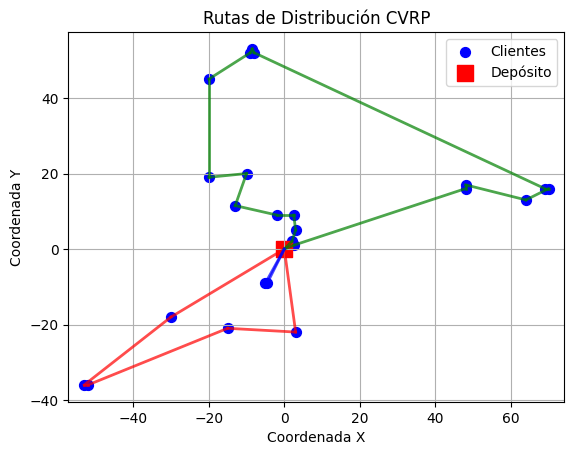

In [ ]:
from posixpath import join
import pandas as pd
!pip install ortools
import matplotlib.pyplot as plt
import numpy as np
!pip install gurobipy
from gurobipy import *
#carga de datos
df = pd.read_excel('/content/TC 2025-1 datos.xlsx')

#nodos
n=26
clientes= [i for i in range(n)if i != 0]
nodos = [0] +clientes
arcos = [(i,j) for i in nodos for j in nodos if i!=j]

#demanda
q=df['Demanda']
Q=2000

#coordenadas
X=df['X']
Y=df['Y']

#distancia
distancia={(i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in nodos for j in nodos if i!=j}
depot= X[0],Y[0]


#creacion del modelo
model = Model('CVRP')

#variables
x = model.addVars(arcos,vtype=GRB.BINARY,name='x')
u = model.addVars(nodos,vtype=GRB.INTEGER,name='u')

#funcion objetivo
model.setObjective(quicksum(distancia[n]*x[n] for n in arcos),GRB.MINIMIZE)

#restricciones
num_camiones = 4
model.addConstrs(quicksum(x[i,j] for j in nodos if j!=i)==1 for i in clientes)
model.addConstrs(quicksum(x[i,j] for i in nodos if i!=j)==1 for j in clientes)
model.addConstr(quicksum(x[0,j] for j in clientes)==4 ) #cuando sale y vuelve el camion
model.addConstr(quicksum(x[i,0] for i in clientes)==4)
model.addConstrs((x[i,j]==1)>> (u[i]+q[j]==u[j]) for i,j in arcos if j!=0 and i!=0)   #eliminar subtour
model.addConstrs(u[i]>=q[i] for i in clientes)     #cumplir la demanda
model.addConstrs(u[i]<=Q for i in clientes)
model.addConstr(u[0]==0)
model.addConstrs(u[i]+q[j]-u[j]<=Q*(1-x[i,j]) for i,j in arcos if j!=0 and i!=0) #capacidad por camion

model.Params.TimeLimit = 350
#model.Params.MIPGap = 0.1
model.optimize()

#imprimir valores
print("Funcion Objetivo:", str(round(model.ObjVal,2)))
for v in model.getVars():
  if v.x>0.9:
    print(v.varName+"="+str(v.x))

#para graficar la solucion
rutas=list()
for i in clientes:
  if x[(0,i)].x>0.9:
    aux=[0,i]
    while i!=0:
      j=i
      for k in nodos:
        if j!=k and x[(j,k)].x > 0.9:
          aux.append(k)
          i=k
    rutas.append(aux)

print("Rutas Encontradas:")
for idx, ruta in enumerate(rutas):
    print(f"Ruta {idx + 1}: {ruta}")
    distancia_ruta = 0
    for n in range(len(ruta) - 1):
        i = ruta[n]
        j = ruta[n+1]
        distancia_ruta += distancia[(i,j)]
    print(f"Distancia total de la Ruta {idx + 1}: {round(distancia_ruta, 2)}")

# Dibujar nodos: depósito en rojo y clientes en azul
plt.scatter(X[clientes], Y[clientes], color='blue', label='Clientes', s=50)
plt.scatter(X[0], Y[0], color='red', s=120, marker='s', label='Depósito')


# Colores para las rutas (puedes agregar más si hay más vehículos)
colores = ['red', 'green', 'blue', 'orange']

# Dibujar rutas con líneas (sin flechas)
for idx, ruta in enumerate(rutas):
    color = colores[idx % len(colores)]
    for n in range(len(ruta)-1):
        i = ruta[n]
        j = ruta[n+1]
        plt.plot([X[i], X[j]], [Y[i], Y[j]], color=color, linewidth=2, alpha=0.7)

plt.title("Rutas de Distribución CVRP")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.grid(True)
plt.legend()
plt.axis('equal')  # para mantener proporciones reales
plt.show()

Camión 1 ruta: [0, 21, 20, 19, 22, 23, 25, 0] dist= 131.29960990800888
Camión 2 ruta: [0, 6, 7, 8, 0] dist= 171.0449034178078
Camión 3 ruta: [0, 16, 17, 18, 11, 12, 13, 14, 10, 0] dist= 132.30939313824553
Camión 4 ruta: [0, 5, 4, 3, 2, 1, 9, 15, 24, 0] dist= 150.90154949732448
Rango final: 39.74529350979893


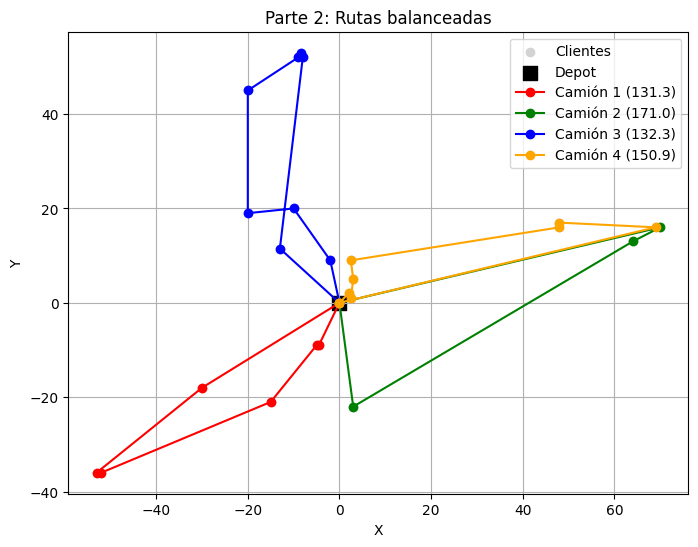

In [ ]:
#PARTE 2 Balance de rutas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, hypot

#Carga datos
df = pd.read_excel('/content/TC 2025-1 datos.xlsx')
n = 26
clientes = [i for i in range(n) if i != 0]
q = {i: int(df.loc[i, 'Demanda']) for i in clientes}
Q = 2000
coords = {i: (df.loc[i,'X'], df.loc[i,'Y']) for i in range(n)}

#Ángulos para Sweep
depot = coords[0]
angles = {i: atan2(coords[i][1]-depot[1], coords[i][0]-depot[0]) for i in clientes}
sorted_clients = sorted(clientes, key=lambda i: angles[i])

#Asignación sweep con capacidad
routes = [[] for _ in range(4)]
load = [0]*4
cur = 0
for i in sorted_clients:
    if load[cur] + q[i] > Q:
        cur += 1
        if cur==4:
            cur = 3  # forzar últimos si sobra, pero Q total >> demanda total
    routes[cur].append(i)
    load[cur] += q[i]
# ahora cada cliente está en alguna ruta

#Heurístico TSP por ruta: inserción más cercana
def tsp_insert(nodes):
    if not nodes: return [0,0]
    route = [0, nodes[0], 0]
    for v in nodes[1:]:
        best_pos, best_inc = None, float('inf')
        for k in range(len(route)-1):
            inc = hypot(coords[route[k]][0]-coords[v][0], coords[route[k]][1]-coords[v][1]) \
                + hypot(coords[v][0]-coords[route[k+1]][0], coords[v][1]-coords[route[k+1]][1]) \
                - hypot(coords[route[k]][0]-coords[route[k+1]][0], coords[route[k]][1]-coords[route[k+1]][1])
            if inc < best_inc:
                best_inc, best_pos = inc, k+1
        route.insert(best_pos, v)
    return route

routes = [tsp_insert(r) for r in routes]

# función distancia
def route_dist(r):
    return sum(hypot(coords[a][0]-coords[b][0], coords[a][1]-coords[b][1])
               for a,b in zip(r[:-1], r[1:]))

dists = [route_dist(r) for r in routes]

#Iterativo de swaps para balancear
for _ in range(500):
    # ubicar más largo y más corto
    k_short = int(np.argmin(dists))
    k_long  = int(np.argmax(dists))
    if dists[k_long] - dists[k_short] < 0.5:
        break
    improved = False
    for idx, cust in enumerate(routes[k_long]):
        if cust==0: continue
        # probar mover cust de long→short
        new_long = routes[k_long][:idx] + routes[k_long][idx+1:]
        for pos in range(1, len(routes[k_short])):
            new_short = routes[k_short][:pos] + [cust] + routes[k_short][pos:]
            # verificar capacidad
            if sum(q[i] for i in new_short if i!=0) > Q: continue
            d_long2  = route_dist(new_long)
            d_short2 = route_dist(new_short)
            new_range = max(d_long2, d_short2, *[dists[i] for i in range(4) if i not in (k_long,k_short)]) \
                        - min(d_long2, d_short2, *[dists[i] for i in range(4) if i not in (k_long,k_short)])
            old_range = dists[k_long] - dists[k_short]
            if new_range < old_range:
                routes[k_long]  = new_long
                routes[k_short] = new_short
                dists[k_long], dists[k_short] = d_long2, d_short2
                improved = True
                break
        if improved: break
    if not improved: break

#Mostrar resultados
for v, r in enumerate(routes):
    print(f"Camión {v+1} ruta:", r, "dist=", dists[v])

print("Rango final:", max(dists)-min(dists))

#Graficar
colors = ['red','green','blue','orange']
plt.figure(figsize=(8,6))
plt.scatter([coords[i][0] for i in clientes],[coords[i][1] for i in clientes],
            c='lightgray', label='Clientes')
plt.scatter(*depot, c='black', s=100, marker='s', label='Depot')
for v, r in enumerate(routes):
    xs = [coords[i][0] for i in r]; ys = [coords[i][1] for i in r]
    plt.plot(xs, ys, '-o', color=colors[v], label=f'Camión {v+1} ({dists[v]:.1f})')
plt.title('Parte 2: Rutas balanceadas')
plt.xlabel('X'); plt.ylabel('Y'); plt.grid(True); plt.legend(); plt.show()


Cluster 0: 13 clientes, demanda=2587, ruta=[0, 24, 10, 18, 17, 16, 2, 1, 15, 9, 8, 19, 20, 21, 0], dist=131.3
Cluster 1: 3 clientes, demanda=1259, ruta=[0, 25, 23, 22, 0], dist=128.4
Cluster 2: 5 clientes, demanda=147, ruta=[0, 7, 6, 5, 4, 3, 0], dist=145.6
Cluster 3: 4 clientes, demanda=656, ruta=[0, 14, 13, 12, 11, 0], dist=117.1


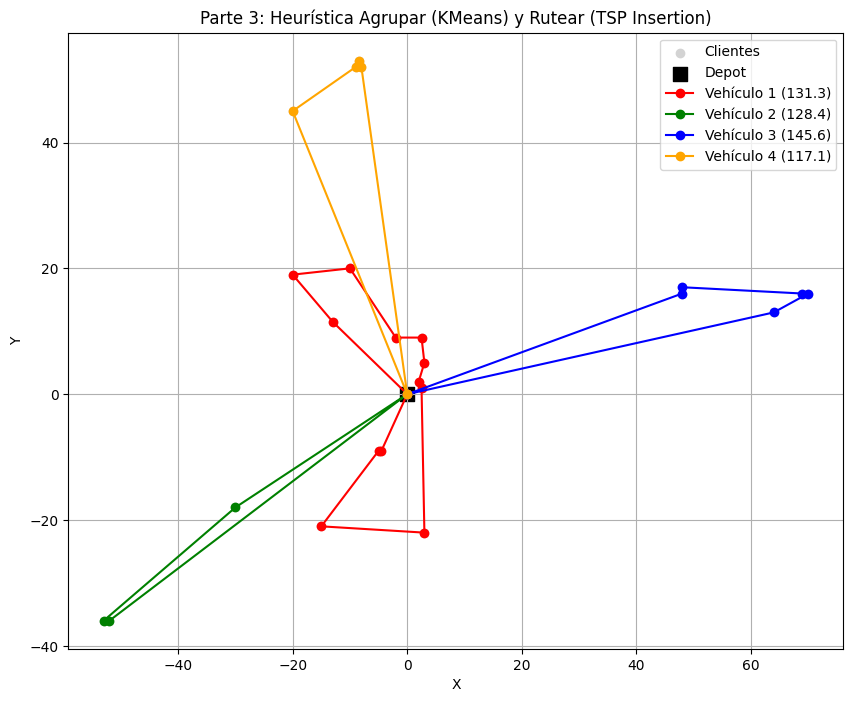

In [ ]:
#PARTE 3: Heurística Agrupar y Rutear(KMeans + TSP Insertion)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from math import hypot

#Carga de datos
df = pd.read_excel('/content/TC 2025-1 datos.xlsx')
n = 26
clientes = [i for i in range(n) if i != 0]
coords = {i: (df.loc[i,'X'], df.loc[i,'Y']) for i in range(n)}
q = {i: int(df.loc[i,'Demanda']) for i in clientes}
Q = 2000

#Agrupamiento con KMeans sobre coordenadas de clientes
client_coords = np.array([coords[i] for i in clientes])
kmeans = KMeans(n_clusters=4, random_state=42).fit(client_coords)
labels = kmeans.labels_

#Construir diccionario cluster -> lista de clientes
cluster_clients = {c: [] for c in range(4)}
for idx, client in enumerate(clientes):
    cluster_clients[labels[idx]].append(client)

#Función TSP por inserción más cercana
def tsp_insert(nodes):
    # nodes incluye depot=0 al inicio y final
    if len(nodes) <= 2:
        return [0] + [n for n in nodes if n!=0] + [0]
    route = [0, nodes[1], 0]
    for v in nodes[2:]:
        best_inc, best_pos = float('inf'), None
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            inc = (hypot(coords[i][0]-coords[v][0], coords[i][1]-coords[v][1]) +
                   hypot(coords[v][0]-coords[j][0], coords[v][1]-coords[j][1]) -
                   hypot(coords[i][0]-coords[j][0], coords[i][1]-coords[j][1]))
            if inc < best_inc:
                best_inc, best_pos = inc, k+1
        route.insert(best_pos, v)
    return route

def route_dist(route):
    return sum(hypot(coords[a][0]-coords[b][0], coords[a][1]-coords[b][1])
               for a,b in zip(route[:-1], route[1:]))

#Para cada cluster, construir y graficar la ruta TSP
colors = ['red','green','blue','orange']
plt.figure(figsize=(10,8))
plt.scatter(*zip(*[coords[i] for i in clientes]), c='lightgray', label='Clientes')
plt.scatter(*coords[0], c='black', s=100, marker='s', label='Depot')

for c in range(4):
    group = cluster_clients[c]
    # Incluye depot
    nodes_c = [0] + group
    route = tsp_insert(nodes_c)
    dist = route_dist(route)
    print(f"Cluster {c}: {len(group)} clientes, demanda={sum(q[i] for i in group)}, ruta={route}, dist={dist:.1f}")
    xs = [coords[i][0] for i in route]
    ys = [coords[i][1] for i in route]
    plt.plot(xs, ys, '-o', color=colors[c], label=f'Vehículo {c+1} ({dist:.1f})')

plt.title('Parte 3: Heurística Agrupar (KMeans) y Rutear (TSP Insertion)')
plt.xlabel('X'); plt.ylabel('Y'); plt.grid(True); plt.legend(); plt.show()


3 VEHÍCULOS: 
Camión 1: ruta=[0, 2, 15, 21, 20, 19, 22, 23, 25, 0], dist=150.4
Camión 2: ruta=[0, 24, 3, 4, 5, 6, 7, 8, 0], dist=172.9
Camión 3: ruta=[0, 1, 9, 16, 17, 18, 11, 12, 13, 14, 10, 0], dist=142.1
Total 3 veh: 465.37023929352597

 4 VEHÍCULOS: 
Camión 1: ruta=[0, 21, 20, 19, 22, 23, 25, 0], dist=131.3
Camión 2: ruta=[0, 6, 7, 8, 0], dist=171.0
Camión 3: ruta=[0, 16, 17, 18, 11, 12, 13, 14, 10, 0], dist=132.3
Camión 4: ruta=[0, 5, 4, 3, 2, 1, 9, 15, 24, 0], dist=150.9
Total 4 veh: 585.5554559613868


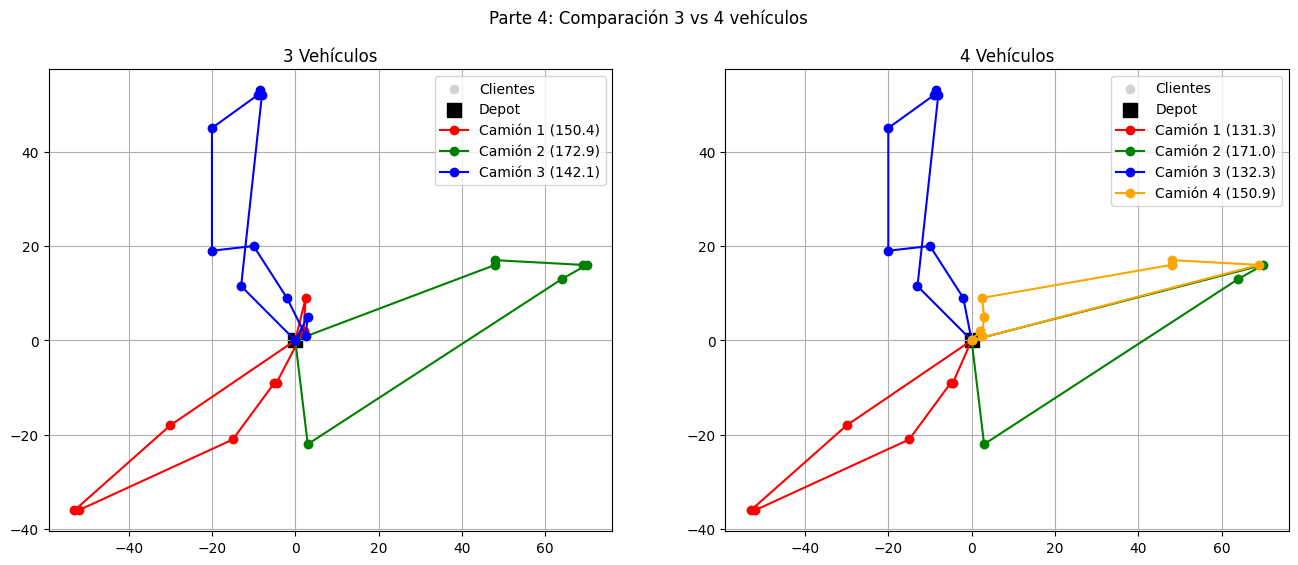

In [ ]:
#PARTE 4: Reducción de flota a 3 vehículos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, hypot

#Carga de datos
df = pd.read_excel('/content/TC 2025-1 datos.xlsx')
n = 26
clientes = [i for i in range(n) if i != 0]
q = {i: int(df.loc[i, 'Demanda']) for i in clientes}
Q = 2000
coords = {i: (df.loc[i,'X'], df.loc[i,'Y']) for i in range(n)}
depot = coords[0]

#Funciones auxiliares
def route_dist(route):
    return sum(hypot(coords[a][0]-coords[b][0], coords[a][1]-coords[b][1])
               for a, b in zip(route[:-1], route[1:]))

def tsp_insert(nodes):
    if len(nodes) <= 2:
        return [0] + [n for n in nodes if n!=0] + [0]
    route = [0, nodes[1], 0]
    for v in nodes[2:]:
        best_inc, best_pos = float('inf'), None
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            inc = (hypot(coords[i][0]-coords[v][0], coords[i][1]-coords[v][1]) +
                   hypot(coords[v][0]-coords[j][0], coords[v][1]-coords[j][1]) -
                   hypot(coords[i][0]-coords[j][0], coords[i][1]-coords[j][1]))
            if inc < best_inc:
                best_inc, best_pos = inc, k+1
        route.insert(best_pos, v)
    return route

#Construir asignación inicial tipo Sweep para K vehículos
def initial_routes(K):
    angles = {i: atan2(coords[i][1]-depot[1], coords[i][0]-depot[0]) for i in clientes}
    sorted_clients = sorted(clientes, key=lambda i: angles[i])
    routes = [[] for _ in range(K)]
    loads  = [0]*K
    cur = 0
    for i in sorted_clients:
        if loads[cur] + q[i] > Q and cur < K-1:
            cur += 1
        routes[cur].append(i)
        loads[cur] += q[i]
    return routes

#Función para construir y balancear rutas
def build_and_balance(K, raw_routes):
    # 4.1 TSP insertion inicial
    tsp_routes = []
    dists = []
    for r in raw_routes:
        nodes = [0] + r
        rt = tsp_insert(nodes)
        tsp_routes.append(rt)
        dists.append(route_dist(rt))
    # 4.2 Swaps iterativos para nivelar distancias
    for _ in range(500):
        k_short = int(np.argmin(dists))
        k_long  = int(np.argmax(dists))
        if dists[k_long] - dists[k_short] < 0.5:
            break
        improved = False
        for idx, cust in enumerate(tsp_routes[k_long]):
            if cust == 0:
                continue
            new_long = tsp_routes[k_long][:idx] + tsp_routes[k_long][idx+1:]
            for pos in range(1, len(tsp_routes[k_short])):
                new_short = tsp_routes[k_short][:pos] + [cust] + tsp_routes[k_short][pos:]
                if sum(q[n] for n in new_short if n!=0) > Q:
                    continue
                d_long2  = route_dist(new_long)
                d_short2 = route_dist(new_short)
                # calcular nuevo rango global
                other = [dists[i] for i in range(K) if i not in (k_long, k_short)]
                new_range = max([d_long2, d_short2] + other) - min([d_long2, d_short2] + other)
                old_range = dists[k_long] - dists[k_short]
                if new_range < old_range:
                    tsp_routes[k_long]  = new_long
                    tsp_routes[k_short] = new_short
                    dists[k_long], dists[k_short] = d_long2, d_short2
                    improved = True
                    break
            if improved:
                break
        if not improved:
            break
    return tsp_routes, dists

#Ejecutar para K=3 y comparar con K=4
routes3 = initial_routes(3)
tsp3, d3 = build_and_balance(3, routes3)

routes4 = initial_routes(4)
tsp4, d4 = build_and_balance(4, routes4)

print("3 VEHÍCULOS: ")
for v, rt in enumerate(tsp3):
    print(f"Camión {v+1}: ruta={rt}, dist={d3[v]:.1f}")
print("Total 3 veh:", sum(d3))

print("\n 4 VEHÍCULOS: ")
for v, rt in enumerate(tsp4):
    print(f"Camión {v+1}: ruta={rt}, dist={d4[v]:.1f}")
print("Total 4 veh:", sum(d4))

#Graficar comparación
fig, axs = plt.subplots(1, 2, figsize=(16,6))
for ax, (tsp_routes, dists, title) in zip(axs, [(tsp3, d3, "3 Vehículos"), (tsp4, d4, "4 Vehículos")]):
    ax.scatter([coords[i][0] for i in clientes], [coords[i][1] for i in clientes],
               color='lightgray', label='Clientes')
    ax.scatter(*depot, color='black', marker='s', s=100, label='Depot')
    colors = ['red','green','blue','orange'][:len(tsp_routes)]
    for k, route in enumerate(tsp_routes):
        xs = [coords[i][0] for i in route]
        ys = [coords[i][1] for i in route]
        ax.plot(xs, ys, '-o', color=colors[k], label=f'Camión {k+1} ({dists[k]:.1f})')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plt.suptitle("Parte 4: Comparación 3 vs 4 vehículos")
plt.show()
